Goal

    Predict the average pm25 value at pre-defined times in Seoul

1. Sum up three datasets
2. Choose ones to use
3. Feature engineering
4. Set difference for ML and DL models

## Sum up three datasets
-----
**tables**  
1. weather (mile per hour), 08-07-01 to 18-04-10
2. weather (meter per sec), 14-01-01 to 18-12-31
3. aqi(air quality index), 08-01-01 to 18-06-18 11:00:00

**to do**  
1. concat mps datasets and mph as weather
2. merge aqi and weather

-> totally, 2018-07-01 to 2018-06-17 23:00:00

In [654]:
import pandas as pd
import numpy as np
import os

In [655]:
path_wwo = 'dataset/weather_wwo'
path_wwo_seoul_1 = os.path.join(path_wwo, 'weather_seoul_2008_2018mph.csv') # mph
path_wwo_seoul_2 = os.path.join(path_wwo, 'weather_seoul_2014_2018_mps.csv') # mps

columns = ['time', 'overall', 'temp', 'feels', 'wind_speed', 'wind_direction', 'gust', 'cloud', 'humidity',
          'precipitation', 'pressure', 'loc']
seoul_mph = pd.read_csv(path_wwo_seoul_1, header=None, names=columns)
seoul_mps = pd.read_csv(path_wwo_seoul_2, header=None, names=columns)

/Users/jonas/opt/anaconda3/envs/dl/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [656]:
print('period mph dataset')
print(seoul_mph.iloc[0].time)
print(seoul_mph.iloc[-1].time)
print('period mps dataset')
print(seoul_mps.iloc[0].time)
print(seoul_mps.iloc[-1].time)

period mph dataset
2008-07-01 00:00:00
2018-04-10 23:00:00
period mps dataset
2014-01-01 00:00:00
2018-12-31 23:00:00


In [657]:
cols2 = ['time', 'district', 'pm10_con', 'pm25_con', 'o3', 'no2', 'co', 'so2',
        'pm10_aqi', 'pm25_aqi']
aqi = pd.read_csv('dataset/seoul_air.csv', header=None, names=cols2)
print(aqi.shape)
print(aqi.iloc[0][0])
print(aqi.iloc[-1][0])

(2369634, 10)
2008-01-01 01:00:00
2018-06-18 11:00:00


**Final dataset to use**  
2008-07-01 - 2018-04-10 (mph) + 2018-04-11 - 2018-06-17 (mps)  
2008-07-01 - 2018-06-17 (aqi)  

**MPS to MPH**  
- Since, MPH already has been applied int() work.  
- The number of samples in MPH is far larger than the other.

In [658]:
# cut mps
start_idx = seoul_mps.loc[seoul_mps['time']=='2018-04-11 00:00:00'].index.item()
end_idx = seoul_mps.loc[seoul_mps['time']=='2018-06-17 23:00:00'].index.item()
mps = seoul_mps[start_idx:end_idx+1]
mps.head(3)

,time,overall,temp,feels,wind_speed,wind_direction,gust,cloud,humidity,precipitation,pressure,loc
37464,2018-04-11 00:00:00,Moderate rain at times,14,12,8.6,SW,11.9,69,82,3.1,1005,seoul
37465,2018-04-11 01:00:00,Moderate rain at times,14,12,8.6,SW,11.9,69,82,3.1,1005,seoul
37466,2018-04-11 02:00:00,Moderate rain at times,14,12,8.6,SW,11.9,69,82,3.1,1005,seoul


In [659]:
mps.tail(3)

,time,overall,temp,feels,wind_speed,wind_direction,gust,cloud,humidity,precipitation,pressure,loc
39093,2018-06-17 21:00:00,Partly cloudy,24,26,0.8,NNW,1.1,51,52,0.0,1009,seoul
39094,2018-06-17 22:00:00,Partly cloudy,24,26,0.8,NNW,1.1,51,52,0.0,1009,seoul
39095,2018-06-17 23:00:00,Partly cloudy,24,26,0.8,NNW,1.1,51,52,0.0,1009,seoul


In [660]:
# apply convert function mps to mph
def mps_to_mph(spd):
    return int(spd*3600*0.000621)

mps['wind_speed'] = mps['wind_speed'].apply(mps_to_mph)
mps['gust'] = mps['gust'].apply(mps_to_mph)

mps.head(3)

<ipython-input-660-b7b9af59f5df>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mps['wind_speed'] = mps['wind_speed'].apply(mps_to_mph)
<ipython-input-660-b7b9af59f5df>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mps['gust'] = mps['gust'].apply(mps_to_mph)


,time,overall,temp,feels,wind_speed,wind_direction,gust,cloud,humidity,precipitation,pressure,loc
37464,2018-04-11 00:00:00,Moderate rain at times,14,12,19,SW,26,69,82,3.1,1005,seoul
37465,2018-04-11 01:00:00,Moderate rain at times,14,12,19,SW,26,69,82,3.1,1005,seoul
37466,2018-04-11 02:00:00,Moderate rain at times,14,12,19,SW,26,69,82,3.1,1005,seoul


In [661]:
# cut aqi from 2008-07-01
aqi.loc[aqi['time']=='2008-07-01 00:00:00'].head(1)

,time,district,pm10_con,pm25_con,o3,no2,co,so2,pm10_aqi,pm25_aqi
111579,2008-07-01 00:00:00,0,25.0,15.0,0.016,0.031,0.4,0.004,23.0,57.0


In [662]:
aqi.loc[aqi['time']=='2018-06-17 23:00:00'].tail(1)

,time,district,pm10_con,pm25_con,o3,no2,co,so2,pm10_aqi,pm25_aqi
2369321,2018-06-17 23:00:00,25,49.0,26.0,0.02,0.04,0.5,0.004,45.0,80.0


In [663]:
aqi_use = aqi[111579:2369322]
aqi_use

,time,district,pm10_con,pm25_con,o3,no2,co,so2,pm10_aqi,pm25_aqi
111579,2008-07-01 00:00:00,0,25.0,15.0,0.016,0.031,0.4,0.004,23.0,57.0
111580,2008-07-01 00:00:00,1,14.0,18.0,0.022,0.022,0.3,0.005,13.0,63.0
111581,2008-07-01 00:00:00,2,22.0,16.0,0.026,0.028,0.5,0.001,20.0,59.0
111582,2008-07-01 00:00:00,3,29.0,17.0,0.007,0.045,0.5,0.002,27.0,61.0
111583,2008-07-01 00:00:00,4,17.0,13.0,0.009,0.042,0.4,0.001,16.0,53.0
...,...,...,...,...,...,...,...,...,...,...
2369317,2018-06-17 23:00:00,21,64.0,41.0,0.032,0.041,0.5,0.003,55.0,115.0
2369318,2018-06-17 23:00:00,22,54.0,34.0,0.031,0.041,0.4,0.003,50.0,97.0
2369319,2018-06-17 23:00:00,23,41.0,32.0,0.036,0.029,0.4,0.005,38.0,93.0
2369320,2018-06-17 23:00:00,24,44.0,36.0,0.031,0.030,0.7,0.003,41.0,102.0


In [664]:
# concat mph and mps
weather = pd.concat([seoul_mph, mps]).reset_index(drop=True)
weather.tail(3)

,time,overall,temp,feels,wind_speed,wind_direction,gust,cloud,humidity,precipitation,pressure,loc
87309,2018-06-17 21:00:00,Partly cloudy,24,26,1,NNW,2,51,52,0.0,1009,seoul
87310,2018-06-17 22:00:00,Partly cloudy,24,26,1,NNW,2,51,52,0.0,1009,seoul
87311,2018-06-17 23:00:00,Partly cloudy,24,26,1,NNW,2,51,52,0.0,1009,seoul


In [665]:
# join weather and aqi
# aqi left outer join
merged = aqi_use.merge(weather, how='left', on='time')
print(aqi_use.shape)
print(weather.shape)
print(merged.shape)
merged.sample(3)

(2257743, 10)
(87312, 12)
(2257743, 21)


,time,district,pm10_con,pm25_con,o3,no2,co,so2,pm10_aqi,pm25_aqi,...,temp,feels,wind_speed,wind_direction,gust,cloud,humidity,precipitation,pressure,loc
253296,2009-08-13 17:00:00,19,45.0,22.0,0.053,0.025,0.6,0.003,42.0,72.0,...,31.0,38.0,7.0,WSW,8.0,0.0,76.0,0.0,1005.0,NaN
341979,2010-01-07 20:00:00,22,51.0,32.0,0.001,0.065,0.6,0.005,47.0,93.0,...,-14.0,-18.0,3.0,NNW,7.0,2.0,99.0,0.0,1026.0,NaN
1432838,2014-10-30 03:00:00,14,59.0,35.0,0.003,0.084,1.3,0.005,53.0,99.0,...,10.0,10.0,2.0,ENE,3.0,3.0,60.0,0.0,1025.0,NaN


## Choose to use
----

**time**  
- use 00, 03, 06, 09, 12, 15, 18, 21h  


**district**  
- only district 0 (avg value of all 25 districts in Seoul)

In [666]:
# district 0
df1 = merged.loc[merged['district']==0].reset_index(drop=True)
print(df1.shape)
df1['district'].value_counts()

(87282, 21)


0    87282
Name: district, dtype: int64

In [667]:
df1['time'] = pd.to_datetime(df1['time'])

def get_hour(time):
    return time.hour
df1['hour'] = df1['time'].apply(get_hour)
df1.sample(3)

,time,district,pm10_con,pm25_con,o3,no2,co,so2,pm10_aqi,pm25_aqi,...,feels,wind_speed,wind_direction,gust,cloud,humidity,precipitation,pressure,loc,hour
67429,2016-03-12 16:00:00,0,46.0,18.0,0.039,0.022,0.4,0.006,43.0,63.0,...,2.0,17.0,SW,20.0,26.0,48.0,0.0,1023.0,NaN,16
29458,2011-11-12 09:00:00,0,41.0,26.0,0.007,0.035,0.6,0.005,38.0,80.0,...,12.0,3.0,WNW,4.0,13.0,81.0,0.0,1018.0,NaN,9
1303,2008-08-24 07:00:00,0,14.0,7.0,0.007,0.020,0.4,0.003,13.0,29.0,...,17.0,5.0,E,9.0,21.0,97.0,0.0,1011.0,NaN,7


In [668]:
df2 = df1.loc[(df1['hour']==3) | (df1['hour']==6) | (df1['hour']==9) | (df1['hour']==12) | (df1['hour']==15)\
             | (df1['hour']==18) | (df1['hour']==21) | (df1['hour']==0)]
df2 = df2.reset_index(drop=True)
print(df2.shape)
print(df2.info())
df2.sample(3)

(29092, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29092 entries, 0 to 29091
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            29092 non-null  datetime64[ns]
 1   district        29092 non-null  int64         
 2   pm10_con        29092 non-null  float64       
 3   pm25_con        29092 non-null  float64       
 4   o3              29092 non-null  float64       
 5   no2             29092 non-null  float64       
 6   co              29092 non-null  float64       
 7   so2             29092 non-null  float64       
 8   pm10_aqi        29092 non-null  float64       
 9   pm25_aqi        29092 non-null  float64       
 10  overall         29084 non-null  object        
 11  temp            29084 non-null  float64       
 12  feels           29084 non-null  float64       
 13  wind_speed      29084 non-null  float64       
 14  wind_direction  29084 non-null  object    

,time,district,pm10_con,pm25_con,o3,no2,co,so2,pm10_aqi,pm25_aqi,...,feels,wind_speed,wind_direction,gust,cloud,humidity,precipitation,pressure,loc,hour
9548,2011-10-09 12:00:00,0,66.0,39.0,0.016,0.042,0.7,0.004,56.0,110.0,...,20.0,4.0,SSW,4.0,58.0,56.0,0.0,1023.0,NaN,12
5893,2010-07-09 15:00:00,0,35.0,23.0,0.079,0.027,0.4,0.004,32.0,74.0,...,29.0,7.0,W,9.0,20.0,67.0,0.6,1007.0,NaN,15
2314,2009-04-16 06:00:00,0,18.0,11.0,0.015,0.022,0.3,0.003,17.0,46.0,...,2.0,5.0,NE,10.0,36.0,94.0,0.0,1014.0,NaN,6


In [669]:
# check null
df2.loc[pd.isnull(df2['wind_direction'])]

,time,district,pm10_con,pm25_con,o3,no2,co,so2,pm10_aqi,pm25_aqi,...,feels,wind_speed,wind_direction,gust,cloud,humidity,precipitation,pressure,loc,hour
10688,2012-02-29 00:00:00,0,53.0,30.0,0.002,0.069,1.1,0.007,49.0,89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
10689,2012-02-29 03:00:00,0,51.0,29.0,0.002,0.059,1.1,0.006,47.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
10690,2012-02-29 06:00:00,0,46.0,28.0,0.002,0.055,1.0,0.007,43.0,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
10691,2012-02-29 09:00:00,0,48.0,27.0,0.004,0.060,1.2,0.008,44.0,82.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
10692,2012-02-29 12:00:00,0,40.0,18.0,0.018,0.043,0.6,0.006,37.0,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
10693,2012-02-29 15:00:00,0,33.0,18.0,0.018,0.046,0.6,0.005,31.0,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
10694,2012-02-29 18:00:00,0,47.0,23.0,0.027,0.042,0.5,0.005,44.0,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
10695,2012-02-29 21:00:00,0,40.0,22.0,0.015,0.049,0.5,0.005,37.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21


In [670]:
df2.loc[pd.isnull(df2['wind_direction'])]

,time,district,pm10_con,pm25_con,o3,no2,co,so2,pm10_aqi,pm25_aqi,...,feels,wind_speed,wind_direction,gust,cloud,humidity,precipitation,pressure,loc,hour
10688,2012-02-29 00:00:00,0,53.0,30.0,0.002,0.069,1.1,0.007,49.0,89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
10689,2012-02-29 03:00:00,0,51.0,29.0,0.002,0.059,1.1,0.006,47.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
10690,2012-02-29 06:00:00,0,46.0,28.0,0.002,0.055,1.0,0.007,43.0,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
10691,2012-02-29 09:00:00,0,48.0,27.0,0.004,0.060,1.2,0.008,44.0,82.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
10692,2012-02-29 12:00:00,0,40.0,18.0,0.018,0.043,0.6,0.006,37.0,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
10693,2012-02-29 15:00:00,0,33.0,18.0,0.018,0.046,0.6,0.005,31.0,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
10694,2012-02-29 18:00:00,0,47.0,23.0,0.027,0.042,0.5,0.005,44.0,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
10695,2012-02-29 21:00:00,0,40.0,22.0,0.015,0.049,0.5,0.005,37.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21


In [671]:
# drop null rows
idx = df2.loc[pd.isnull(df2['wind_direction'])].index
df2 = df2.drop(idx, axis=0).reset_index(drop=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29084 entries, 0 to 29083
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            29084 non-null  datetime64[ns]
 1   district        29084 non-null  int64         
 2   pm10_con        29084 non-null  float64       
 3   pm25_con        29084 non-null  float64       
 4   o3              29084 non-null  float64       
 5   no2             29084 non-null  float64       
 6   co              29084 non-null  float64       
 7   so2             29084 non-null  float64       
 8   pm10_aqi        29084 non-null  float64       
 9   pm25_aqi        29084 non-null  float64       
 10  overall         29084 non-null  object        
 11  temp            29084 non-null  float64       
 12  feels           29084 non-null  float64       
 13  wind_speed      29084 non-null  float64       
 14  wind_direction  29084 non-null  object        
 15  gu

## Feature Engineering
- analyze corr between features
- categoricalize target value (pm25)
- check dtype, range, and re-scaling

In [672]:
df2.corr()

,district,pm10_con,pm25_con,o3,no2,co,so2,pm10_aqi,pm25_aqi,temp,feels,wind_speed,gust,cloud,humidity,precipitation,pressure,hour
district,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pm10_con,NaN,1.000000,0.739838,0.025640,0.397344,0.493574,0.507687,0.880691,0.747735,-0.146319,-0.143040,-0.017274,-0.014780,-0.133792,-0.092901,-0.136309,0.124169,0.032465
pm25_con,NaN,0.739838,1.000000,-0.003568,0.510212,0.638333,0.558348,0.783834,0.964560,-0.102399,-0.084406,-0.171790,-0.159739,-0.075869,0.027199,-0.120369,0.115872,0.005903
o3,NaN,0.025640,-0.003568,1.000000,-0.469579,-0.432151,-0.072798,0.033899,0.002443,0.416538,0.387613,0.273311,0.176624,-0.164368,-0.254670,-0.032596,-0.355291,0.291346
no2,NaN,0.397344,0.510212,-0.469579,1.000000,0.780540,0.495197,0.479126,0.551177,-0.218921,-0.183340,-0.413127,-0.360094,-0.050040,0.014951,-0.110088,0.318242,0.005299
co,NaN,0.493574,0.638333,-0.432151,0.780540,1.000000,0.570337,0.563569,0.664658,-0.381666,-0.345717,-0.269114,-0.221485,-0.026117,0.026772,-0.105500,0.379567,-0.092640
so2,NaN,0.507687,0.558348,-0.072798,0.495197,0.570337,1.000000,0.569545,0.580692,-0.312292,-0.304006,-0.020653,-0.029467,-0.137893,-0.174463,-0.156002,0.296128,0.067088
pm10_aqi,NaN,0.880691,0.783834,0.033899,0.479126,0.563569,0.569545,1.000000,0.822795,-0.168406,-0.162723,-0.044988,-0.046864,-0.169244,-0.125983,-0.174178,0.157128,0.042243
pm25_aqi,NaN,0.747735,0.964560,0.002443,0.551177,0.664658,0.580692,0.822795,1.000000,-0.115142,-0.095445,-0.192677,-0.182016,-0.098133,0.010503,-0.149532,0.135527,0.007347
temp,NaN,-0.146319,-0.102399,0.416538,-0.218921,-0.381666,-0.312292,-0.168406,-0.115142,1.000000,0.992060,-0.190995,-0.215258,0.043430,0.196511,0.122649,-0.705852,0.131550


### corr between features & drop
- drop USA aqi values
- drop feels like temp.
- drop district, loc
- drop humidity, o3: too low corr with pm25_con

In [673]:
list_drop = ['district', 'pm10_aqi', 'pm25_aqi', 'feels', 'loc', 'humidity', 'o3']
df3 = df2.drop(list_drop, axis=1)

In [674]:
df3

,time,pm10_con,pm25_con,no2,co,so2,overall,temp,wind_speed,wind_direction,gust,cloud,precipitation,pressure,hour
0,2008-07-01 00:00:00,25.0,15.0,0.031,0.4,0.004,Clear,21.0,8.0,SSE,13.0,60.0,1.4,1004.0,0
1,2008-07-01 03:00:00,26.0,14.0,0.024,0.4,0.004,Partly cloudy,20.0,8.0,S,12.0,75.0,3.5,1003.0,3
2,2008-07-01 06:00:00,25.0,13.0,0.023,0.4,0.003,Light drizzle,20.0,8.0,S,12.0,98.0,0.6,1004.0,6
3,2008-07-01 09:00:00,26.0,15.0,0.036,0.5,0.004,Light drizzle,20.0,9.0,S,13.0,100.0,1.3,1004.0,9
4,2008-07-01 12:00:00,34.0,20.0,0.031,0.4,0.004,Partly cloudy,25.0,7.0,S,8.0,84.0,0.6,1006.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29079,2018-06-17 09:00:00,61.0,43.0,0.029,0.6,0.004,Sunny,23.0,3.0,SE,3.0,7.0,0.0,1012.0,9
29080,2018-06-17 12:00:00,66.0,45.0,0.025,0.5,0.004,Sunny,27.0,3.0,S,3.0,18.0,0.0,1011.0,12
29081,2018-06-17 15:00:00,55.0,37.0,0.021,0.5,0.004,Partly cloudy,27.0,3.0,WNW,4.0,30.0,0.0,1010.0,15
29082,2018-06-17 18:00:00,56.0,37.0,0.017,0.4,0.004,Partly cloudy,26.0,5.0,WNW,6.0,47.0,0.0,1009.0,18


### categorize values
- overall weather
- wind_direction
- pm25_con

#### pm25

map= {'좋음': 0, '보통': 1, '나쁨': 2, '매우 나쁨': 3}
![pm25_cat](https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F83805ce1-ac17-4e21-b23c-1dfcad7d4e4c%2FUntitled.png?table=block&id=921c1b6c-1ab9-4a2f-84e8-869c26b29881&width=2780&userId=e2e31942-f3c3-401c-98e8-47301f6c7779&cache=v2)

In [675]:
def cat_pm25(val):
    if val < 15:
        return 0
    elif 15 <= val < 35:
        return 1
    elif 36 <= val < 75:
        return 2
    else:
        return 3

df3['pm25_cat'] = df3['pm25_con'].apply(cat_pm25)
df3['pm25_cat'].value_counts()

1    15268
0     7885
2     5069
3      862
Name: pm25_cat, dtype: int64

#### wind_direction
- W, E are more important than others
- the most value in a direction dominate

In [676]:
df3['wind_direction'].value_counts()

NW     3945
WSW    2497
WNW    2324
W      2093
SW     1974
NNW    1850
ENE    1846
SSW    1761
E      1687
ESE    1561
S      1411
SE     1364
SSE    1331
NE     1313
N      1089
NNE    1038
Name: wind_direction, dtype: int64

In [677]:
wind_map = {'NW': 'W', 'WSW': 'W', 'WNW': 'W', 'W': 'W', 'SW': 'W', 'SSW': 'S', 'E': 'E', 'ENE': 'E',
           'ESE': 'E', 'NNW': 'N', 'SE': 'E', 'S': 'S', 'SSE': 'S', 'NE': 'E', 'NNE': 'N', 'N': 'N'}

def cat_wind(val):
    return wind_map[val]
df3['wind_direction'] = df3['wind_direction'].apply(cat_wind)
df3['wind_direction'].value_counts()

W    12833
E     7771
S     4503
N     3977
Name: wind_direction, dtype: int64

In [678]:
wind_map_int = {'W': 0, 'E': 1, 'S': 2, 'N': 3}
def encode_wind(val):
    return wind_map_int[val]
df3['wind_direction'] = df3['wind_direction'].apply(encode_wind)
df3['wind_direction'].value_counts()

0    12833
1     7771
2     4503
3     3977
Name: wind_direction, dtype: int64

#### overall 
- should be used? can find other weather features? cloud, precipitation...
- just falling(rain or snow): 1 or not: 0

In [679]:
df3['overall'].unique()

array(['Clear', 'Partly cloudy', 'Light drizzle', 'Light rain shower',
       'Moderate or heavy rain shower', 'Moderate rain', 'Light rain',
       'Overcast', 'Cloudy', 'Mist', 'Fog', 'Patchy rain possible',
       'Moderate rain at times', 'Patchy light rain', 'Sunny',
       'Heavy rain', 'Torrential rain shower', 'Patchy light drizzle',
       'Patchy light rain with thunder', 'Heavy rain at times',
       'Light snow', 'Patchy snow possible', 'Blowing snow',
       'Moderate snow', 'Light sleet', 'Moderate or heavy sleet',
       'Patchy heavy snow', 'Patchy light snow', 'Patchy moderate snow',
       'Heavy snow', 'Thundery outbreaks possible',
       'Moderate or heavy rain with thunder', 'Blizzard', 'Freezing fog',
       'Patchy sleet possible', 'Freezing drizzle', 'Light sleet showers',
       'Light snow showers', 'Light freezing rain',
       'Moderate or heavy snow showers',
       'Patchy freezing drizzle possible',
       'Moderate or heavy snow with thunder',
       'M

In [680]:
rain = set(['drizzle', 'rain', 'snow', 'sleet'])
def cat_overall(val):
    if set(val.lower().split()) & rain:
        return 1
    else:
        return 0
df3['overall_int'] = df3['overall'].apply(cat_overall)
df3.loc[(df3['overall']=='Freezing fog')|(df3['overall']=='Moderate or heavy sleet'), ['overall', 'overall_int']]

,overall,overall_int
1378,Moderate or heavy sleet,1
4415,Freezing fog,0
4416,Freezing fog,0
4417,Freezing fog,0
4418,Freezing fog,0
4419,Freezing fog,0
4423,Freezing fog,0
4424,Freezing fog,0
4426,Freezing fog,0
4430,Freezing fog,0


In [681]:
df4 = df3.drop('overall', axis=1)
print(df4.shape)
df4.head(3)

(29084, 16)


,time,pm10_con,pm25_con,no2,co,so2,temp,wind_speed,wind_direction,gust,cloud,precipitation,pressure,hour,pm25_cat,overall_int
0,2008-07-01 00:00:00,25.0,15.0,0.031,0.4,0.004,21.0,8.0,2,13.0,60.0,1.4,1004.0,0,1,0
1,2008-07-01 03:00:00,26.0,14.0,0.024,0.4,0.004,20.0,8.0,2,12.0,75.0,3.5,1003.0,3,0,0
2,2008-07-01 06:00:00,25.0,13.0,0.023,0.4,0.003,20.0,8.0,2,12.0,98.0,0.6,1004.0,6,0,1


### Check dtype, range

In [641]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29084 entries, 0 to 29083
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            29084 non-null  datetime64[ns]
 1   pm10_con        29084 non-null  float64       
 2   pm25_con        29084 non-null  float64       
 3   no2             29084 non-null  float64       
 4   co              29084 non-null  float64       
 5   so2             29084 non-null  float64       
 6   temp            29084 non-null  float64       
 7   wind_speed      29084 non-null  float64       
 8   wind_direction  29084 non-null  int64         
 9   gust            29084 non-null  float64       
 10  cloud           29084 non-null  float64       
 11  precipitation   29084 non-null  float64       
 12  pressure        29084 non-null  float64       
 13  hour            29084 non-null  int64         
 14  pm25_cat        29084 non-null  int64         
 15  ov

In [682]:
df4['wind_direction'] = df4['wind_direction'].astype('category')
df4['overall_int'] = df4['overall_int'].astype('category')
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29084 entries, 0 to 29083
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            29084 non-null  datetime64[ns]
 1   pm10_con        29084 non-null  float64       
 2   pm25_con        29084 non-null  float64       
 3   no2             29084 non-null  float64       
 4   co              29084 non-null  float64       
 5   so2             29084 non-null  float64       
 6   temp            29084 non-null  float64       
 7   wind_speed      29084 non-null  float64       
 8   wind_direction  29084 non-null  category      
 9   gust            29084 non-null  float64       
 10  cloud           29084 non-null  float64       
 11  precipitation   29084 non-null  float64       
 12  pressure        29084 non-null  float64       
 13  hour            29084 non-null  int64         
 14  pm25_cat        29084 non-null  int64         
 15  ov

In [683]:
df4.describe()

,pm10_con,pm25_con,no2,co,so2,temp,wind_speed,gust,cloud,precipitation,pressure,hour,pm25_cat
count,29084.000000,29084.000000,29084.000000,29084.000000,29084.000000,29084.000000,29084.000000,29084.000000,29084.000000,29084.000000,29084.000000,29084.000000,29084.000000
mean,46.642106,24.943268,0.032434,0.538423,0.005165,12.587368,5.971943,8.502407,33.306079,0.468110,1016.318663,10.500000,0.962454
std,34.380251,16.482869,0.015168,0.240489,0.002012,10.928954,4.269604,5.851627,34.340039,2.180624,8.056032,6.874027,0.750042
min,3.000000,2.000000,0.003000,0.200000,0.002000,-22.000000,0.000000,0.000000,0.000000,0.000000,980.000000,0.000000,0.000000
25%,27.000000,14.000000,0.020000,0.400000,0.004000,3.000000,3.000000,4.000000,3.000000,0.000000,1010.000000,5.250000,0.000000
50%,40.000000,21.000000,0.030000,0.500000,0.005000,14.000000,5.000000,7.000000,19.000000,0.000000,1017.000000,9.000000,1.000000
75%,58.000000,32.000000,0.042000,0.600000,0.006000,22.000000,8.000000,11.000000,59.000000,0.000000,1023.000000,15.750000,1.000000
max,1125.000000,425.000000,0.112000,2.600000,0.035000,39.000000,37.000000,51.000000,100.000000,87.300000,1038.000000,21.000000,3.000000


use standardization instead of min max scaler. can be used when new max or min value is found.
- o3, no2, co, so2, pressure(too high values)  

check outlier, too high for the average.
- wind speed, gust

In [684]:
from sklearn import preprocessing
cols_standard = ['no2', 'co', 'so2', 'pressure']
scaler = preprocessing.StandardScaler().fit(df4[cols_standard])
modified = pd.DataFrame(scaler.transform(df4[cols_standard]), columns=cols_standard)

df5 = df4.copy()
for col in cols_standard:
    df5[col] = modified[col]
    
df5.describe()

,pm10_con,pm25_con,no2,co,so2,temp,wind_speed,gust,cloud,precipitation,pressure,hour,pm25_cat
count,29084.000000,29084.000000,2.908400e+04,2.908400e+04,2.908400e+04,29084.000000,29084.000000,29084.000000,29084.000000,29084.000000,2.908400e+04,29084.000000,29084.000000
mean,46.642106,24.943268,-3.439844e-16,-1.172674e-16,-2.032635e-16,12.587368,5.971943,8.502407,33.306079,0.468110,3.647016e-15,10.500000,0.962454
std,34.380251,16.482869,1.000017e+00,1.000017e+00,1.000017e+00,10.928954,4.269604,5.851627,34.340039,2.180624,1.000017e+00,6.874027,0.750042
min,3.000000,2.000000,-1.940640e+00,-1.407254e+00,-1.573120e+00,-22.000000,0.000000,0.000000,0.000000,0.000000,-4.508334e+00,0.000000,0.000000
25%,27.000000,14.000000,-8.198124e-01,-5.756008e-01,-5.791137e-01,3.000000,3.000000,4.000000,3.000000,0.000000,-7.843529e-01,5.250000,0.000000
50%,40.000000,21.000000,-1.605023e-01,-1.597739e-01,-8.211046e-02,14.000000,5.000000,7.000000,19.000000,0.000000,8.457619e-02,9.000000,1.000000
75%,58.000000,32.000000,6.306699e-01,2.560529e-01,4.148928e-01,22.000000,8.000000,11.000000,59.000000,0.000000,8.293725e-01,15.750000,1.000000
max,1125.000000,425.000000,5.245841e+00,8.572590e+00,1.482799e+01,39.000000,37.000000,51.000000,100.000000,87.300000,2.691363e+00,21.000000,3.000000


Text(0.5, 1.0, 'gust')

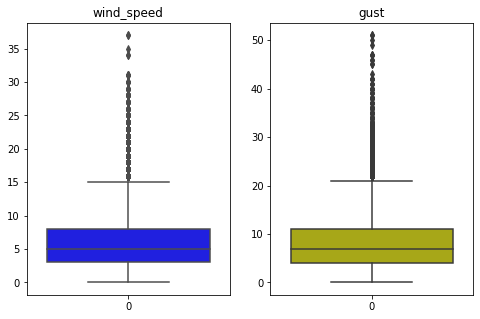

In [685]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
ax1 = plt.subplot(121)
sns.boxplot(data=df5['wind_speed'], color='b').set_title('wind_speed')
as2 = plt.subplot(122)
sns.boxplot(data=df5['gust'], color='y').set_title('gust')

In [686]:
print('percentage more than 15 wind speed: ', sum(df5['wind_speed']>15) / len(df5))
print('percentage more than 25 gust: ', sum(df5['gust']>20) / len(df5))

percentage more than 15 wind speed:  0.03988447256223353
percentage more than 25 gust:  0.050508870856828494


**Only For Machine Learning Models!!**

In [688]:
#only for machine learning models!!

def outlier_ws(val):
    if val >= 20:
        return 20
    else:
        return val

def outlier_gust(val):
    if val >= 30:
        return 30
    else:
        return val

df5['wind_speed_rs'] = df5['wind_speed'].apply(outlier_ws)
df5['gust_rs'] = df5['gust'].apply(outlier_gust)
df5[['wind_speed', 'wind_speed_rs', 'gust', 'gust_rs']].describe()

,wind_speed,wind_speed_rs,gust,gust_rs
count,29084.000000,29084.000000,29084.000000,29084.000000
mean,5.971943,5.933297,8.502407,8.470430
std,4.269604,4.111161,5.851627,5.708375
min,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,4.000000,4.000000
50%,5.000000,5.000000,7.000000,7.000000
75%,8.000000,8.000000,11.000000,11.000000
max,37.000000,20.000000,51.000000,30.000000


In [690]:
#only for machine learning models!

df6 = df5.drop(['wind_speed', 'gust'], axis=1)
df6.columns

Index(['time', 'pm10_con', 'pm25_con', 'no2', 'co', 'so2', 'temp',
       'wind_direction', 'cloud', 'precipitation', 'pressure', 'hour',
       'pm25_cat', 'overall_int', 'wind_speed_rs', 'gust_rs'],
      dtype='object')

## Two type Datasets
1. past variables (timestep t-1) + current variables (timestep t) -> pm25 cat
    - for **non-sequential** model (ML classifier)
    - t-1 var.: PM25, NO2, CO, SO2
    - t var.: others
2. all current -> pm25 cat
    - for **sequential model** (LSTM encoders)

In [645]:
df6.corr()[['pm25_cat', 'pm25_con']]

,pm25_cat,pm25_con
pm10_con,0.681735,0.736265
pm25_con,0.825885,1.000000
no2,0.518490,0.510006
co,0.586300,0.610829
so2,0.528261,0.554955
temp,-0.101356,-0.098259
cloud,-0.094986,-0.079454
precipitation,-0.135410,-0.117084
pressure,0.128446,0.119467
hour,0.012136,0.014503


for dataset 1

In [691]:
# for set 1
past = ['no2', 'co', 'so2', 'pm25_con']
cur = ['time', 'temp', 'wind_direction', 'cloud', 'precipitation', 'pressure', 'wind_speed_rs', 'gust_rs', 'overall_int', 'pm25_cat']

past_array = list()
for i in past:
    past_array.append(df6[i][:-1].reset_index(drop=True))
cur_array = list()
for i in cur:
    cur_array.append(df6[i][1:].reset_index(drop=True))

In [692]:
cols = past+cur
data = past_array+cur_array
dataset1 = pd.DataFrame(columns=cols)
for i in range(len(cols)):
    dataset1[cols[i]] = data[i]
print(dataset1.shape)

(29083, 14)


for dataset 2

In [693]:
cols_dl = ['no2', 'co', 'so2', 'pm25_con', 'time', 'temp', 'wind_direction', 'cloud', 'precipitation',
           'pressure', 'wind_speed', 'gust', 'overall_int', 'pm25_cat']

In [694]:
# for set 2
dataset2 = df5[cols_dl]
dataset2.shape

(29084, 14)

In [695]:
# more standaridization for dl models
from sklearn import preprocessing
cols_standard = ['pm25_con', 'temp', 'cloud', 'precipitation', 'wind_speed', 'gust']
scaler = preprocessing.StandardScaler().fit(dataset2[cols_standard])
modified = pd.DataFrame(scaler.transform(dataset2[cols_standard]), columns=cols_standard)

dataset3 = dataset2.copy()
for col in cols_standard:
    dataset3[col] = modified[col]
    
dataset3.describe()

,no2,co,so2,pm25_con,temp,cloud,precipitation,pressure,wind_speed,gust,pm25_cat
count,2.908400e+04,2.908400e+04,2.908400e+04,2.908400e+04,2.908400e+04,2.908400e+04,2.908400e+04,2.908400e+04,2.908400e+04,2.908400e+04,29084.000000
mean,-3.439844e-16,-1.172674e-16,-2.032635e-16,-9.967729e-17,-9.185947e-17,-3.908913e-17,5.472479e-17,3.647016e-15,-7.622381e-17,8.599610e-17,0.962454
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,0.750042
min,-1.940640e+00,-1.407254e+00,-1.573120e+00,-1.391970e+00,-3.164801e+00,-9.699072e-01,-2.146714e-01,-4.508334e+00,-1.398735e+00,-1.453024e+00,0.000000
25%,-8.198124e-01,-5.756008e-01,-5.791137e-01,-6.639291e-01,-8.772598e-01,-8.825441e-01,-2.146714e-01,-7.843529e-01,-6.960820e-01,-7.694414e-01,0.000000
50%,-1.605023e-01,-1.597739e-01,-8.211046e-02,-2.392384e-01,1.292582e-01,-4.166077e-01,-2.146714e-01,8.457619e-02,-2.276464e-01,-2.567547e-01,1.000000
75%,6.306699e-01,2.560529e-01,4.148928e-01,4.281326e-01,8.612712e-01,7.482334e-01,-2.146714e-01,8.293725e-01,4.750069e-01,4.268276e-01,1.000000
max,5.245841e+00,8.572590e+00,1.482799e+01,2.427148e+01,2.416799e+00,1.942195e+00,3.982043e+01,2.691363e+00,7.267323e+00,7.262650e+00,3.000000


In [697]:
dataset1.to_csv('dataset/for_ML.csv', index=False)
dataset3.to_csv('dataset/for_Seq.csv', index=False)